In [ ]:
! git clone https://github.com/FlashChoi5657/Lung_segmentation

Cloning into 'Lung_segmentation'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 46 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 68.65 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
!pip install livelossplot --quiet

In [ ]:
# 현재 위치의 파일 및 폴더 리스트 출력
!ls

Lung_segmentation  sample_data


In [ ]:
!pwd

/content


In [ ]:
# 데이터셋 다운로드 (깃허브)
!rm -rf *
!git clone https://github.com/FlashChoi5657/Lung_segmentation.git

Cloning into 'Lung_segmentation'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 46 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 68.65 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
# 데이터셋 압축풀기
%cd Lung_segmentation
!cat images.tar.gz* | tar -zxvpf -
!cat masks.tar.gz* | tar -zxvpf -
!rm *
%cd ..

/content/Lung_segmentation
images/
images/CHNCXR_0001_0.png
images/CHNCXR_0002_0.png
images/CHNCXR_0003_0.png
images/CHNCXR_0004_0.png
images/CHNCXR_0005_0.png
images/CHNCXR_0006_0.png
images/CHNCXR_0007_0.png
images/CHNCXR_0008_0.png
images/CHNCXR_0009_0.png
images/CHNCXR_0010_0.png
images/CHNCXR_0011_0.png
images/CHNCXR_0012_0.png
images/CHNCXR_0013_0.png
images/CHNCXR_0014_0.png
images/CHNCXR_0015_0.png
images/CHNCXR_0016_0.png
images/CHNCXR_0017_0.png
images/CHNCXR_0018_0.png
images/CHNCXR_0019_0.png
images/CHNCXR_0020_0.png
images/CHNCXR_0021_0.png
images/CHNCXR_0022_0.png
images/CHNCXR_0023_0.png
images/CHNCXR_0024_0.png
images/CHNCXR_0026_0.png
images/CHNCXR_0027_0.png
images/CHNCXR_0028_0.png
images/CHNCXR_0029_0.png
images/CHNCXR_0030_0.png
images/CHNCXR_0031_0.png
images/CHNCXR_0032_0.png
images/CHNCXR_0033_0.png
images/CHNCXR_0034_0.png
images/CHNCXR_0035_0.png
images/CHNCXR_0041_0.png
images/CHNCXR_0042_0.png
images/CHNCXR_0043_0.png
images/CHNCXR_0044_0.png
images/CHNCXR_0

In [ ]:
!ls Lung_segmentation

images	masks


In [ ]:
# load library
import numpy as np
import os
import glob
import cv2

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

data_path = "./Lung_segmentation/"

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1


x_list = sorted(glob.glob(data_path+'images/*'))
y_list = sorted(glob.glob(data_path+'masks/*'))
print(len(x_list),len(y_list),x_list[:4],y_list[:4])


539 539 ['./Lung_segmentation/images/CHNCXR_0001_0.png', './Lung_segmentation/images/CHNCXR_0002_0.png', './Lung_segmentation/images/CHNCXR_0003_0.png', './Lung_segmentation/images/CHNCXR_0004_0.png'] ['./Lung_segmentation/masks/CHNCXR_0001_0_mask.png', './Lung_segmentation/masks/CHNCXR_0002_0_mask.png', './Lung_segmentation/masks/CHNCXR_0003_0_mask.png', './Lung_segmentation/masks/CHNCXR_0004_0_mask.png']


In [ ]:
X_all = np.zeros((len(x_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
y_all = np.zeros((len(y_list), IMG_HEIGHT, IMG_WIDTH, 1),  dtype=bool)

for idx in range(len(x_list)):

    img = cv2.imread(x_list[idx], cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_COLOR > (width, height, 3) , cv2.IMREAD_GRAYSCALE > (width, height)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = np.expand_dims(img, -1)

    mask = imread(y_list[idx])
    mask = cv2.resize(mask,(IMG_WIDTH,IMG_HEIGHT))
    mask = np.expand_dims(mask, axis=-1)

    X_all[idx] = img
    y_all[idx] = mask

In [ ]:
X_all.shape, y_all.shape

((539, 128, 128, 1), (539, 128, 128, 1))

In [ ]:
import matplotlib.pyplot as plt

# 해당 데이터셋의 랜덤 이미지 보기
def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(np.squeeze(a[ix]), cmap='gray')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]), cmap='gray')
        plt.axis('off')
        plt.show()

# 상위 a, 하위 b 퍼센트 cutoff 하기
def image_preprocess_float(x,x_cutoff_max=100,x_cutoff_min=0):
    """
    Scale image to range 0..1 for correct plot
    """
    x_max = np.percentile(x, x_cutoff_max)
    x_min = np.percentile(x, x_cutoff_min)

    if x_max - x_min != 0:
        x = (x - x_min) / (x_max - x_min)
        x = x.clip(0, 1).astype('float32')
    elif x_max - x_min == 0:
        x = np.zeros_like(x)
    return x

In [ ]:
# 8bit 이미지를 255로 나누기 (0,1,...255) --> (0,...,1)
X_all = X_all.astype('float32') / 255.

# 8bit 이미지에서 상위 2% 하위 2% 제외하고 0~1사이로 정규화 (0,1,...255) --> (0,...,1)
X_all = image_preprocess_float(X_all,98,2)

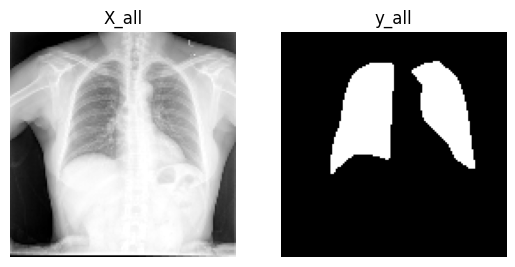

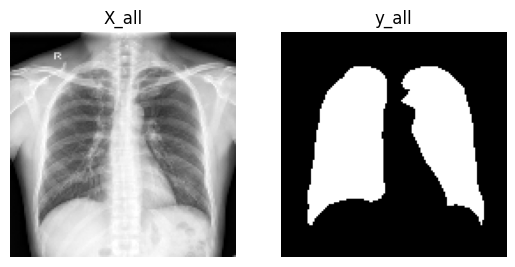

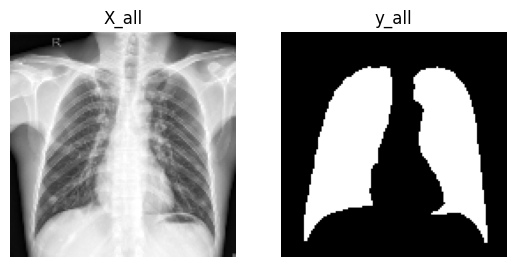

In [ ]:
plotTrainData(X_all, y_all, 'all')

In [ ]:
# fix random seed for reproductibility
seed = 5
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
# Check the shape of input
# image input for Keras (N:sample,H:Height,W:Width,C:Channel)
# image input for Pytorch (N:sample,C:Channel,H:Height,W:Width)

print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train (436, 128, 128, 1)
X_valid (49, 128, 128, 1)
X_test (54, 128, 128, 1)
y_train (436, 128, 128, 1)
y_valid (49, 128, 128, 1)
y_test (54, 128, 128, 1)


In [ ]:
!pip install seaborn


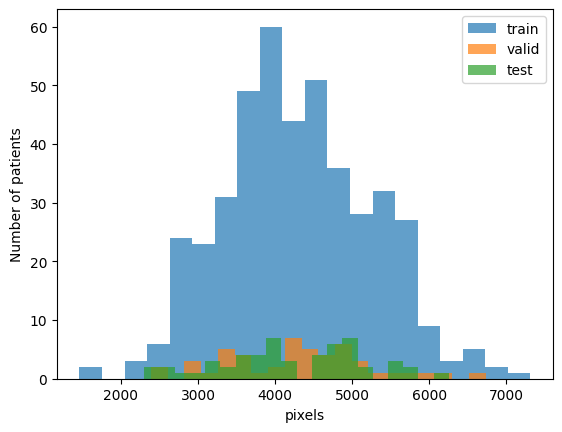

In [ ]:
import matplotlib.pyplot as plt
# 데이터셋별 pixel수 비교

y_pixel_train = []
y_pixel_valid = []
y_pixel_test = []

for idx in range(len(y_train)):
  y_pixel_train.append(np.count_nonzero(y_train[idx]))

for idx in range(len(y_valid)):
  y_pixel_valid.append(np.count_nonzero(y_valid[idx]))

for idx in range(len(y_test)):
  y_pixel_test.append(np.count_nonzero(y_test[idx]))

plt.style.use('default')
plt.hist(y_pixel_train,bins=20,alpha=0.7,label='train')
plt.hist(y_pixel_valid,bins=20,alpha=0.7,label='valid')
plt.hist(y_pixel_test,bins=20,alpha=0.7,label='test')
plt.xlabel('pixels')
plt.ylabel('Number of patients')
plt.legend()

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Cropping2D

def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Contracting Path
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Expanding Path
    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    # Remove Cropping2D or adjust cropping to match shapes
    # up7 = Cropping2D(((1, 0), (1, 0)))(up7)  # 크기 조정 - This line caused the shape mismatch
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])




In [ ]:
model = unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 128, 128, 32)   │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 128, 128, 32)   │            128 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 128, 128, 32)   │            128 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 64, 64, 32)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 64, 64, 64)     │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 64, 64, 64)     │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 32, 32, 128)    │            512 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 32, 32, 128)    │            512 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,930,657 (7.36 MB)

 Trainable params: 1,927,841 (7.35 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
import tensorflow.keras.backend as K  # Import from tensorflow.keras.backend

def dice_coef(y_true, y_pred):
    y_true_f = K.cast(y_true, dtype='float32') # Now K.cast should work correctly
    y_true_f = K.flatten(y_true_f)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# visualizer
from livelossplot import PlotLossesKeras
import tensorflow as tf

plotlosses = PlotLossesKeras()

# build the model
model = unet()
adam = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
model.compile(loss=dice_coef_loss, optimizer=adam, metrics=['accuracy',dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# hyper parameter
batch_size = 16
epochs=30

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


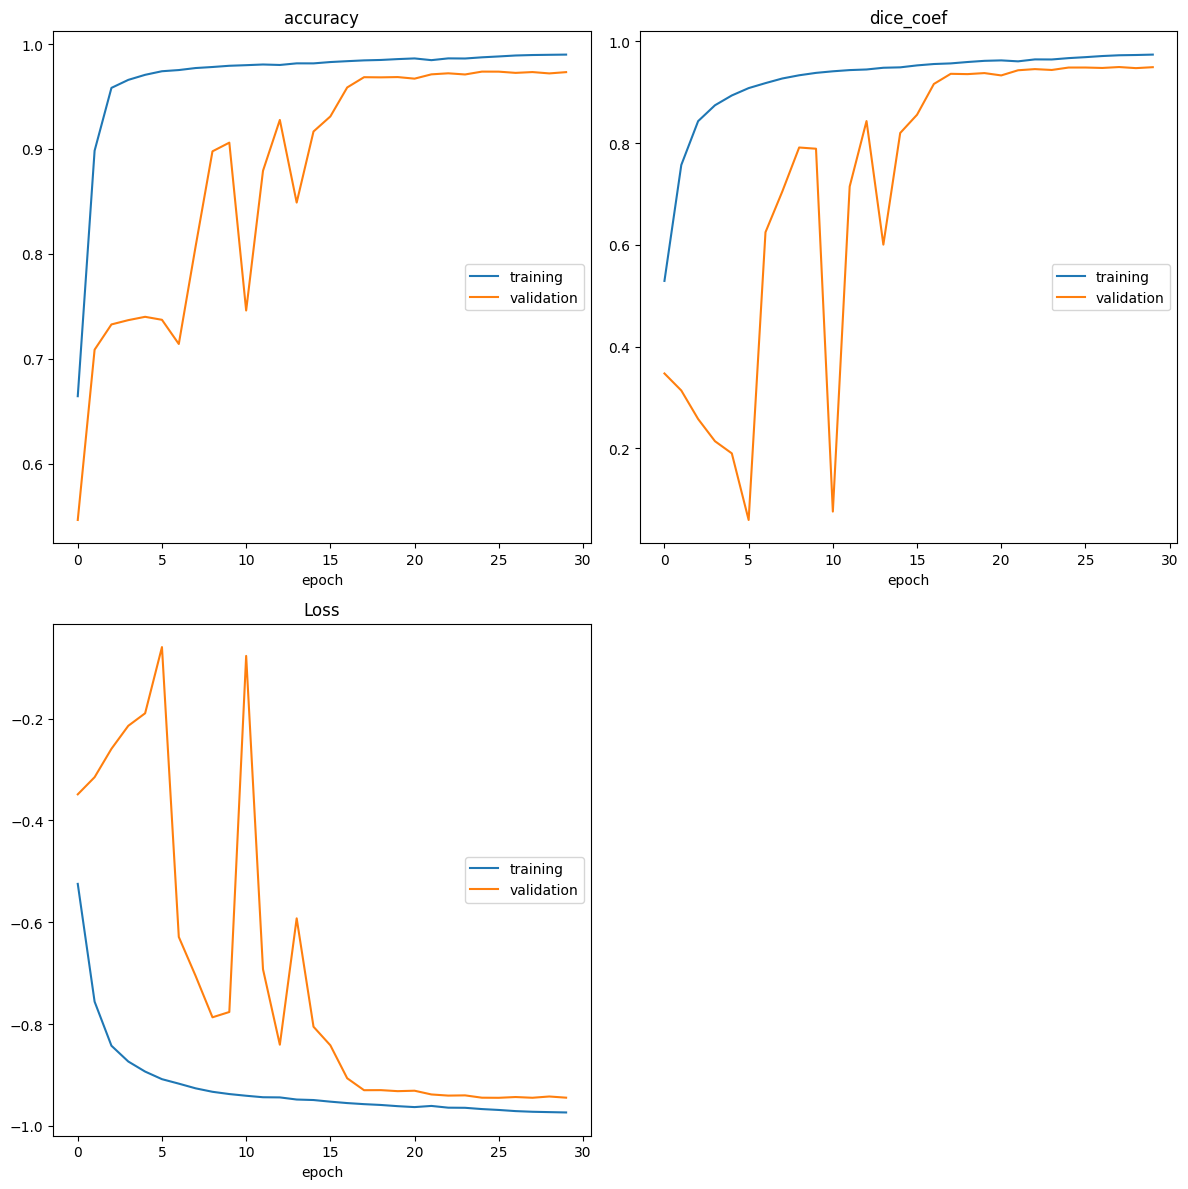

accuracy
	training         	 (min:    0.664, max:    0.990, cur:    0.990)
	validation       	 (min:    0.546, max:    0.974, cur:    0.973)
dice_coef
	training         	 (min:    0.529, max:    0.974, cur:    0.974)
	validation       	 (min:    0.060, max:    0.949, cur:    0.949)
Loss
	training         	 (min:   -0.974, max:   -0.525, cur:   -0.974)
	validation       	 (min:   -0.945, max:   -0.060, cur:   -0.945)
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9901 - dice_coef: 0.9742 - loss: -0.9742 - val_accuracy: 0.9732 - val_dice_coef: 0.9491 - val_loss: -0.9446


In [ ]:
# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[plotlosses])
model.save('unet.h5')

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, unet):
    model = unet

    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0][:,:,0], 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    preds_valid_t = (preds_valid > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_valid")
    plt.axis('off')
    plt.imshow(input_[0][:,:,0], 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_valid")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_valid_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0][:,:,0], 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9901 - dice_coef: 0.9820 - loss: -0.9820


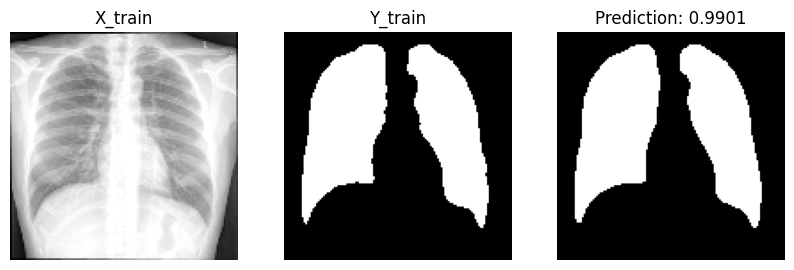

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9890 - dice_coef: 0.9596 - loss: -0.9596


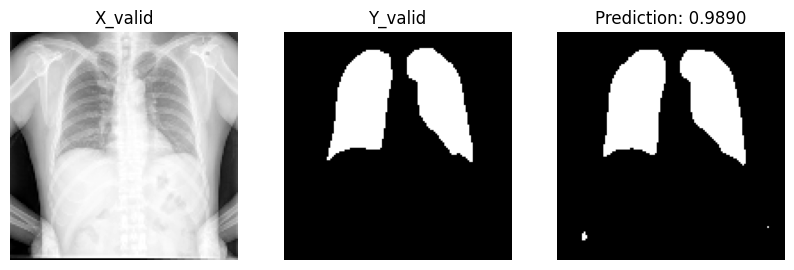

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9819 - dice_coef: 0.9540 - loss: -0.9540


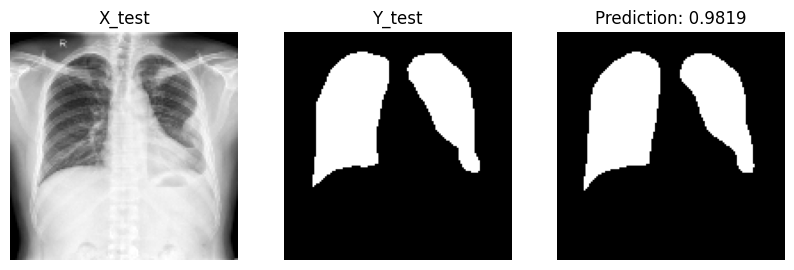

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)